<a href="https://colab.research.google.com/github/wvirany/NeuralNetwork/blob/history_dict/NeuralNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [142]:
# Numpy is used for the majority of matrix operations, matplotlib is for visuals
import numpy as np
import matplotlib.pyplot as plt

# Using pandas and sklearn for data fetching and initial preprocessing
import pandas as pd
from sklearn import datasets

In [143]:
# Fetching the data from sklearn.datasets:

X, y = datasets.fetch_openml('mnist_784',
                             version=1,
                             as_frame=True,
                             return_X_y=True,
                             parser='auto')

In [144]:
X = np.array(X).reshape(70000, 784, 1) / 255.0
y = np.array(y, dtype='int')

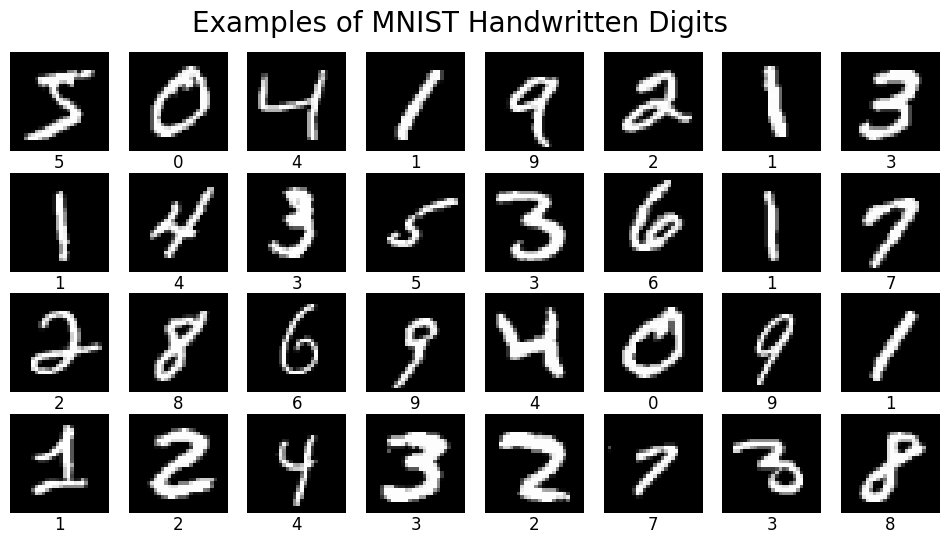

In [145]:
fig, axes = plt.subplots(nrows=4, ncols = 8, figsize=(12, 6))

for i in range(4):
  for j in range(8):
    axes[i, j].axis('off')
    axes[i, j].imshow(X[8*i+j].reshape(28, 28), cmap='gray')
    axes[i, j].set_title(y[8*i+j], y=-.25)

fig.suptitle('Examples of MNIST Handwritten Digits', y=.95, fontsize=20);

In [146]:
def One_Hot(y):
  '''
  Encodes categorical variables as one-hot vector,
  e.g. 3 becomes [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
  '''
  one_hot_y = np.zeros((y.size, y.max() + 1))
  one_hot_y[np.arange(y.size), y] = 1

  return one_hot_y

In [147]:
y = One_Hot(y)

In [148]:
X_train, X_test = X[5000:, :, :], X[:5000, :, :]
y_train, y_test = y[5000:, :], y[:5000, :]

In [149]:
'''
Layer:
  Used as parent class for all layers in network architecture.
  Defines input and output attributes, as well as
  forward and backward propagation functions
'''
class Layer():
  def __init__(self):
    self.input=None
    self.output=None

  def forward_prop(self, input):
    # Forward propagation function to be specified for each layer
    pass

  def backward_prop(self, output_gradient, learning_rate):
    # Backward propagation function to be specified for each layer
    pass

In [150]:
'''
Dense Layer:
  Used as the dense layer object in building neural network models

  Inherits the Layer class
'''
class Dense(Layer):
  def __init__(self, input_size, output_size):
    '''
    Initializes weight matrix and bias vector with
    elements from a standard normal distribution
    '''
    self.weights = np.random.randn(output_size, input_size) # Dimensions j x i
    self.biases = np.random.randn(output_size, 1) # Dimensions j x 1

  '''
  Forward Propagation:
    Computes forward propagation of the dense layer
    as described by the matrix equation Y = WX + b
  '''
  def forward_prop(self, input):
    self.input = input  # Setting input attribute
    return np.dot(self.weights, self.input) + self.biases

  '''
  Backward Propagation:
    Inputs:
    output_gradient - The gradient of the cost function with
      respect to the output of this layer
    learning_rate - The learning rate as specified by the
      training function

    Updates the weight matrix and bias vector and passes the
    gradient of the input back to the previous layer
  '''
  def backward_prop(self, output_gradient, learning_rate):
    weights_gradient = np.dot(output_gradient, self.input.T)
    input_gradient = np.dot(self.weights.T, output_gradient)
    self.weights -= learning_rate * weights_gradient
    self.biases -= learning_rate * output_gradient
    return input_gradient

In [151]:
'''
Activation Layer:
  Used as the activation function for each layer

  Inherits the Layer class
'''
class Activation(Layer):
  '''
  Initializes activation function and its derivative, which
  are specified by the specific activation function classes
  '''
  def __init__(self, activation, d_activation):
    self.activation = activation
    self.d_activation = d_activation

  '''
  Forward Propagation:
    Computes the activation function for each node
    passed by the previous layer
  '''
  def forward_prop(self, input):
    self.input = input
    return self.activation(input)

  '''
  Backward Propagation:
    Inputs:
    output_gradient - The gradient of the cost function with
      respect to the output of this layer
    learning_rate - The learning rate as specified by the
      training function

    Updates the weight matrix and bias vector and passes the
    gradient of the input back to the previous layer
  '''
  def backward_prop(self, output_gradient, learning_rate):
    return np.multiply(output_gradient, self.d_activation(self.input))

In [152]:
'''
ReLU:
  'Rectified Linear Unit' activation function, which
  computes the piecewise function f(x) = max{0,x}

  Inherits the Activation class
'''
class ReLU(Activation):
  def __init__(self):
    # np.maximum() performs element-wise max operation, as opposed to np.max()
    relu = lambda x: np.maximum(0, x)
    # Derivative is 1 for positive x, 0 for negative x:
    d_relu = lambda x: (x > 0)
    # Initializing Activation layer with ReLU:
    super().__init__(relu, d_relu)

In [153]:
'''
Softmax:
  Computes the softmax() function, scaling all elements
  of X to a value between 0 and 1, each of which can be
  interpeted as the probability of a given classification
'''
class Softmax(Layer):
  def forward_prop(self, input):
    # Shifting all input values to avoid overflow errors
    input = input - np.max(input)
    self.output = np.exp(input) / np.sum(np.exp(input))
    return self.output

  def backward_prop(self, output_gradient, learning_rate):
    '''
    Recall that self.output is just the function applied to the input,
    the '-' and '*' operators perform the element-wise operation on the axis
    it shares with the given vector
    '''
    n = np.size(self.output)
    return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)

In [154]:
# mse: Computes the mean-squared error between prediction and observation
def mse(y_pred, y_true):
  return np.mean(np.power(y_true - y_pred, 2))

# d_mse: Computes the derivative of the mean-squared error for a prediction
def d_mse(y_pred, y_true):
  return 2 * (y_pred.T - y_true).T / np.size(y_true)

In [158]:
class Network():
  def __init__(self, layers):

    self.layers = layers
    self.history = {'Accuracy':[],
                   'Validation Accuracy':[]}

  '''
  Predict:
    Given an input, makes a prediction by propagating
    through each layer
  '''
  def predict(self, input):
    output = input

    # Loop through layers, repeatedly updating output
    for layer in self.layers:
      output = layer.forward_prop(output)

    return output

  def train(self, X, y, cost, d_cost, validation_split=.2, epochs=30, batch_size=32, learning_rate=.01, verbose=True):

    size = X.shape[0]

    # Splitting data into training set and validation set for CV
    split = int(validation_split * size)
    X_train, X_val = X[split:], X[:split]
    y_train, y_val = y[split:], y[:split]

    for epoch in range(epochs):
      count = 0
      val_count = 0
      # z = np.random.permutation(batch_size)

      for x, y in zip(X_train, y_train):

        # Forward Pass:
        output = self.predict(x)

        # Backward Pass:
        grad = d_cost(output, y)
        for layer in reversed(self.layers):
          grad = layer.backward_prop(grad, learning_rate)

        if np.argmax(output) == np.argmax(y):
          count += 1

      # Computing training accuracy
      accuracy = count / (size - split)

      # Computing validation accuracy
      for x, y in zip(X_val, y_val):
        output = self.predict(x)
        if np.argmax(output) == np.argmax(y):
          val_count +=1

      val_accuracy = val_count / split

      if verbose:
        print('Epoch: %d/%d' % (epoch+1, epochs))
        print(f'Training Accuracy: {accuracy:.2%} - Validation Accuracy: {val_accuracy:.2%}')

      # Stores accuracy at each epoch
      self.history['Accuracy'].append(accuracy)
      self.history['Validation Accuracy'].append(val_accuracy)

In [159]:
# Initializing network object
network = Network([
    Dense(784, 40),
    ReLU(),
    Dense(40, 10),
    Softmax()
])

In [160]:
network.train(X_train, y_train, mse, d_mse, epochs=30, batch_size=32, learning_rate=.03)

Epoch: 1/30
Training Accuracy: 45.54% - Validation Accuracy: 59.11%
Epoch: 2/30
Training Accuracy: 62.18% - Validation Accuracy: 65.04%
Epoch: 3/30
Training Accuracy: 67.30% - Validation Accuracy: 68.69%
Epoch: 4/30
Training Accuracy: 71.86% - Validation Accuracy: 74.84%
Epoch: 5/30
Training Accuracy: 80.52% - Validation Accuracy: 83.36%
Epoch: 6/30
Training Accuracy: 85.20% - Validation Accuracy: 85.20%
Epoch: 7/30
Training Accuracy: 86.99% - Validation Accuracy: 86.17%
Epoch: 8/30
Training Accuracy: 88.15% - Validation Accuracy: 87.76%
Epoch: 9/30
Training Accuracy: 88.75% - Validation Accuracy: 88.22%
Epoch: 10/30
Training Accuracy: 89.26% - Validation Accuracy: 88.55%
Epoch: 11/30
Training Accuracy: 89.59% - Validation Accuracy: 88.99%
Epoch: 12/30
Training Accuracy: 90.28% - Validation Accuracy: 89.25%
Epoch: 13/30
Training Accuracy: 90.57% - Validation Accuracy: 89.44%
Epoch: 14/30
Training Accuracy: 90.84% - Validation Accuracy: 89.62%
Epoch: 15/30
Training Accuracy: 91.03% - Va

In [161]:
# Computing test accuracy
right = 0
preds = []

for x, y in zip(X_test, y_test):
    output = np.argmax(network.predict(x))
    preds.append(output)
    if output == np.argmax(y):
      right +=1

print('Test Accuracy:', right / X_test.shape[0])

Test Accuracy: 0.9282


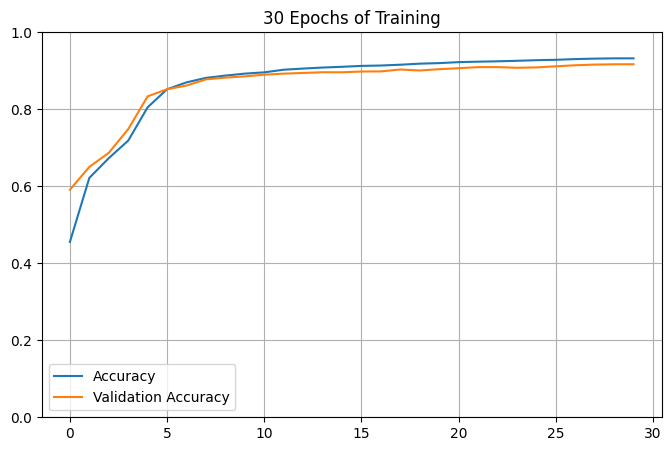

In [163]:
history = pd.DataFrame(network.history)
history.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.title('30 Epochs of Training')
plt.show()

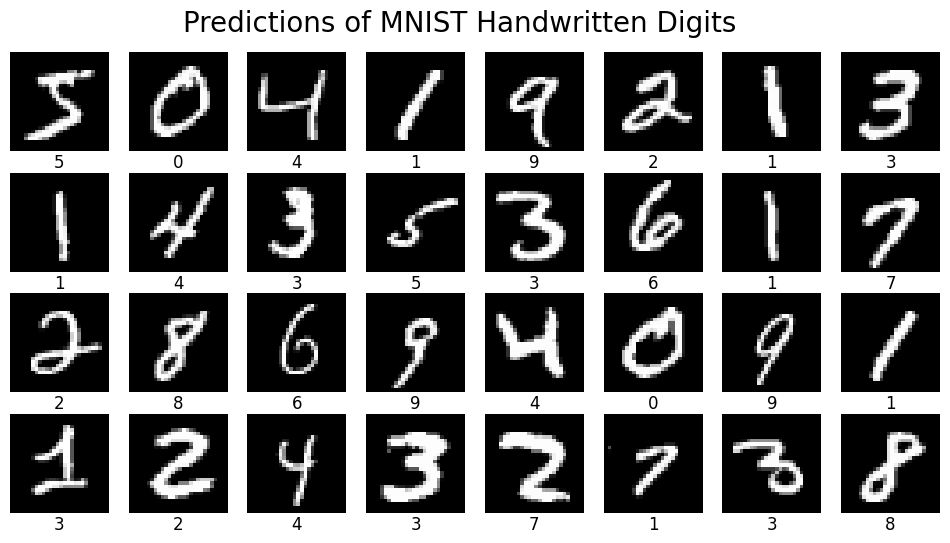

In [164]:
fig, axes = plt.subplots(nrows=4, ncols = 8, figsize=(12, 6))

for i in range(4):
  for j in range(8):
    axes[i, j].axis('off')
    axes[i, j].imshow(X_test[8*i+j].reshape(28, 28), cmap='gray')
    axes[i, j].set_title(preds[8*i+j], y=-.25)

fig.suptitle('Predictions of MNIST Handwritten Digits', y=.95, fontsize=20);